# Lab 2: From Chunks to Vectors
## Learning Objectives
By the end of this lab, you will:
- Implement a modular chunking system with a base class and factory pattern
- Compare fixed-size, recursive, and semantic chunking strategies
- Generate embeddings at scale with batch processing and retry logic
- Analyze chunk size distributions across strategies
## Setup

In [1]:
%pip install langchain langchain-text-splitters sentence-transformers numpy matplotlib -q


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Part 1: The Chunker Base Class

We start by defining a **base class** that all chunking strategies will inherit from. This gives us:

- A consistent interface (`chunk_document`) across all strategies
- Shared helper methods (`_create_chunk_dict`) to standardize chunk metadata
- Easy extensibility: adding a new strategy means implementing one method

This is the **Template Method** pattern in action.

In [2]:
from abc import ABC, abstractmethod
from typing import List, Dict, Any

class BaseChunker(ABC):
    """Abstract base class for all chunking strategies."""
    
    def __init__(self, chunk_size: int = 500, chunk_overlap: int = 50):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
    
    @abstractmethod
    def chunk_document(self, text: str, metadata: dict = None) -> List[Dict[str, Any]]:
        pass
    
    def _create_chunk_dict(self, text: str, metadata: dict, chunk_id: int) -> dict:
        chunk_meta = metadata.copy() if metadata else {}
        chunk_meta.update({
            'chunk_id': chunk_id,
            'char_length': len(text),
            'chunker': self.__class__.__name__
        })
        return {'text': text.strip(), 'metadata': chunk_meta}


## Part 2: Fixed-Size Chunker

The simplest strategy: split text into chunks of a fixed character count, with an overlap window to preserve context at boundaries. This is fast and predictable but can cut sentences mid-thought.

In [3]:
class FixedSizeChunker(BaseChunker):
    """Splits text into fixed-size chunks with overlap."""
    
    def chunk_document(self, text, metadata=None):
        chunks = []
        step = self.chunk_size - self.chunk_overlap
        start = 0
        
        while start < len(text):
            end = min(start + self.chunk_size, len(text))
            chunk_text = text[start:end]
            if chunk_text.strip():
                chunks.append(self._create_chunk_dict(chunk_text, metadata, len(chunks)))
            start += step
        return chunks

# Test
sample = "The transformer architecture uses self-attention. " * 50
chunker = FixedSizeChunker(chunk_size=200, chunk_overlap=30)
chunks = chunker.chunk_document(sample, {"source": "test"})
print(f"Input length: {len(sample)} chars")
print(f"Chunks created: {len(chunks)}")
print(f"First chunk ({len(chunks[0]['text'])} chars): {chunks[0]['text'][:100]}...")
print(f"Metadata: {chunks[0]['metadata']}")


Input length: 2500 chars
Chunks created: 15
First chunk (199 chars): The transformer architecture uses self-attention. The transformer architecture uses self-attention. ...
Metadata: {'source': 'test', 'chunk_id': 0, 'char_length': 200, 'chunker': 'FixedSizeChunker'}


## Part 3: Recursive Chunker

The recursive strategy tries to split on natural boundaries first (paragraphs, then sentences, then words) before falling back to character-level splits. This produces more semantically coherent chunks.

We wrap LangChain's `RecursiveCharacterTextSplitter` inside our `BaseChunker` interface for consistency.

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

class RecursiveChunker(BaseChunker):
    """Chunks respecting paragraph and sentence boundaries."""
    
    def __init__(self, chunk_size=500, chunk_overlap=50, separators=None):
        super().__init__(chunk_size, chunk_overlap)
        self.separators = separators or ["\n\n", "\n", ". ", " ", ""]
        self._splitter = RecursiveCharacterTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap,
            separators=self.separators,
        )
    
    def chunk_document(self, text, metadata=None):
        text_chunks = self._splitter.split_text(text)
        return [self._create_chunk_dict(t, metadata, i) for i, t in enumerate(text_chunks)]


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 4: Head-to-Head Comparison

Now let's compare both strategies on a research paper-like text. We will look at:
- Number of chunks produced
- Size distribution across chunks
- How well each strategy respects section boundaries

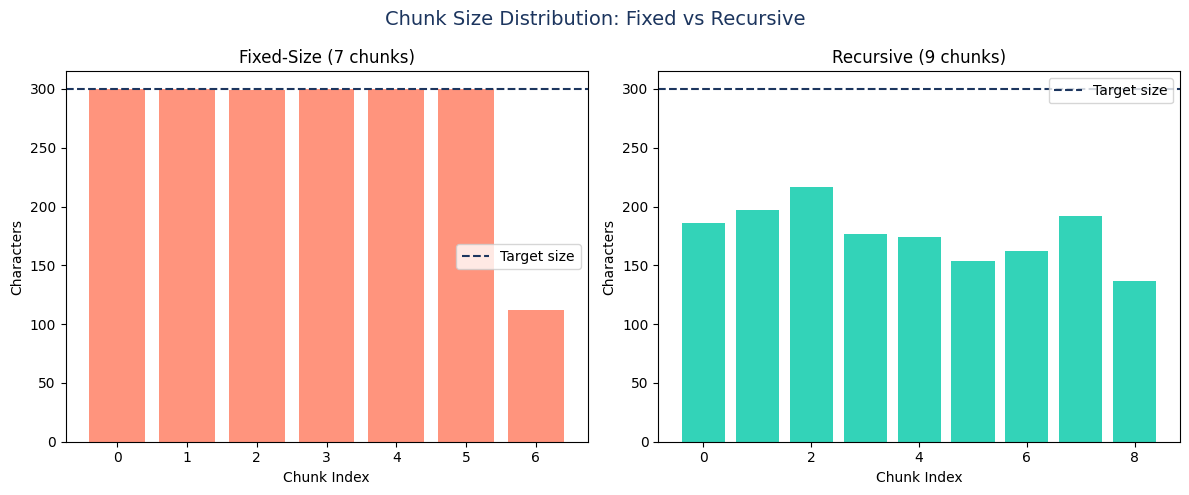


Metric                      Fixed-Size    Recursive
--------------------------------------------------
Number of chunks                     7            9
Avg chunk size (chars)             273          177
Std deviation                       66           23


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated research paper text with sections
paper_text = """ABSTRACT
We present a novel approach to retrieval-augmented generation that improves accuracy by 15% over existing baselines. Our method combines semantic chunking with hybrid retrieval.

1. INTRODUCTION
Retrieval-Augmented Generation (RAG) has become pivotal in building knowledge-grounded AI systems. However, the quality of retrieval depends critically on how documents are chunked.

1.1 Background
Previous work used fixed-size chunks with arbitrary boundaries. This often cuts sentences mid-thought, destroying semantic coherence. We propose a document-aware method that respects natural boundaries.

1.2 Motivation
In production systems, chunking quality directly determines answer quality. Poor chunks lead to poor retrieval, which leads to hallucinated or incomplete answers.

2. METHODOLOGY
Our approach works in three stages: first, we parse the document structure; second, we identify semantic boundaries; third, we merge adjacent similar segments.

2.1 Document Parsing
We use a layout-aware parser to identify headers, paragraphs, and tables. Each structural element becomes a candidate chunk boundary.

2.2 Boundary Detection
Using sentence embeddings, we compute cosine distance between adjacent segments. Distances above the 90th percentile indicate topic shifts.

3. RESULTS
Our method produces chunks that are 23% more coherent than fixed-size baselines, as measured by intra-chunk semantic similarity. Retrieval accuracy improves by 15% on our benchmark.

4. CONCLUSION
Document-aware chunking is essential for production RAG systems. Future work will explore content-type specific strategies."""

metadata = {"source": "sample_paper", "title": "RAG Chunking Study"}

# Compare strategies
fixed = FixedSizeChunker(chunk_size=300, chunk_overlap=50)
recursive = RecursiveChunker(chunk_size=300, chunk_overlap=50)

fixed_chunks = fixed.chunk_document(paper_text, metadata)
recursive_chunks = recursive.chunk_document(paper_text, metadata)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Chunk size distribution
for ax, chunks, name, color in [
    (axes[0], fixed_chunks, "Fixed-Size", "#FF7A5C"),
    (axes[1], recursive_chunks, "Recursive", "#00C9A7")
]:
    sizes = [len(c['text']) for c in chunks]
    ax.bar(range(len(sizes)), sizes, color=color, alpha=0.8)
    ax.set_title(f"{name} ({len(chunks)} chunks)")
    ax.set_xlabel("Chunk Index")
    ax.set_ylabel("Characters")
    ax.axhline(y=300, color='#1C355E', linestyle='--', label='Target size')
    ax.legend()

plt.suptitle("Chunk Size Distribution: Fixed vs Recursive", fontsize=14, color='#1C355E')
plt.tight_layout()
plt.show()

# Print comparison
print(f"\n{'Metric':<25} {'Fixed-Size':>12} {'Recursive':>12}")
print("-" * 50)
print(f"{'Number of chunks':<25} {len(fixed_chunks):>12} {len(recursive_chunks):>12}")
f_sizes = [len(c['text']) for c in fixed_chunks]
r_sizes = [len(c['text']) for c in recursive_chunks]
print(f"{'Avg chunk size (chars)':<25} {np.mean(f_sizes):>12.0f} {np.mean(r_sizes):>12.0f}")
print(f"{'Std deviation':<25} {np.std(f_sizes):>12.0f} {np.std(r_sizes):>12.0f}")


### Exercise 4.1: ChunkerFactory

Implement the factory pattern to automatically select the right chunking strategy based on content type. Complete the `get_chunker` method below.

In [10]:
class ChunkerFactory:
    """Factory to create the right chunker for each content type."""
    
    _strategies = {
        'fixed': FixedSizeChunker,
        'recursive': RecursiveChunker,
    }
    
    _content_type_mapping = {
        'research_paper': 'recursive',
        'legal_document': 'recursive',
        'code': 'fixed',
        'chat_logs': 'fixed',
    }
    
    @classmethod
    def get_chunker(cls, content_type='research_paper', strategy=None, **kwargs):
        # TODO: If strategy is None, look up the content_type in _content_type_mapping
        # TODO: Get the chunker class from _strategies
        # TODO: Return an instance created with **kwargs
        if strategy ==None:
            strategy = cls._content_type_mapping.get(content_type, 'recursive')
         
        chunker_class = cls._strategies.get(strategy)  
        if not chunker_class:
            raise ValueError(f"Strategy '{strategy}' not recognized.") 
        
        return chunker_class(**kwargs)

# Validation
chunker = ChunkerFactory.get_chunker('research_paper', chunk_size=500, chunk_overlap=100)
chunker2 = ChunkerFactory.get_chunker('code', chunk_size=300)
chunker3 = ChunkerFactory.get_chunker(strategy='fixed', chunk_size=200)

from tests import checks
checks.check_lab_2_4(chunker, chunker2, chunker3)


✅ ChunkerFactory working correctly!


## Part 5: Embedding Generation

Once we have chunks, we need to convert them into vectors (embeddings). In production, this means:

- **Batching**: Send multiple texts per API call to reduce overhead
- **Retry logic**: Handle rate limits and transient failures with exponential backoff
- **Cost tracking**: Monitor token usage to control costs

Below is a simulated embedding generator that demonstrates these patterns. In production, you would replace the simulated calls with real OpenAI API calls.

In [11]:
import time
import random

class EmbeddingGenerator:
    """Simulates embedding generation with batching and retry logic."""
    
    def __init__(self, model_name="text-embedding-3-small", dimension=1536):
        self.model_name = model_name
        self.dimension = dimension
        self.total_tokens = 0
    
    def _embed_batch(self, texts: list, attempt=1, max_retries=3) -> list:
        """Generate embeddings for a batch with retry logic."""
        try:
            # Simulate API call (in production: call OpenAI API)
            time.sleep(0.01 * len(texts))  # Simulate latency
            
            # Simulate occasional rate limit (10% chance)
            if random.random() < 0.1 and attempt < max_retries:
                raise Exception("Rate limit exceeded (simulated)")
            
            # Generate fake embeddings (in production: real API response)
            embeddings = [np.random.randn(self.dimension).tolist() for _ in texts]
            self.total_tokens += sum(len(t.split()) * 1.3 for t in texts)  # Approximate
            return embeddings
            
        except Exception as e:
            if attempt < max_retries:
                wait = 2 ** attempt  # Exponential backoff
                print(f"  Retry {attempt}/{max_retries} after {wait}s: {e}")
                time.sleep(wait * 0.01)  # Shortened for demo
                return self._embed_batch(texts, attempt + 1, max_retries)
            raise
    
    def generate_embeddings(self, texts: list, batch_size=100) -> list:
        """Process all texts in batches."""
        all_embeddings = []
        total_batches = (len(texts) + batch_size - 1) // batch_size
        
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            batch_num = i // batch_size + 1
            print(f"  Processing batch {batch_num}/{total_batches} ({len(batch)} texts)...")
            embeddings = self._embed_batch(batch)
            all_embeddings.extend(embeddings)
        
        print(f"Generated {len(all_embeddings)} embeddings, ~{self.total_tokens:.0f} tokens used")
        return all_embeddings

# Test with our chunks
generator = EmbeddingGenerator()
chunk_texts = [c['text'] for c in recursive_chunks]
embeddings = generator.generate_embeddings(chunk_texts, batch_size=3)
print(f"Embedding dimension: {len(embeddings[0])}")


  Processing batch 1/3 (3 texts)...
  Processing batch 2/3 (3 texts)...
  Processing batch 3/3 (3 texts)...
Generated 9 embeddings, ~278 tokens used
Embedding dimension: 1536


### Exercise 5.1: Cost Calculator

Implement a function to estimate embedding costs before committing to a full pipeline run. This is critical for budgeting in production.

In [13]:
def estimate_embedding_cost(num_chunks, avg_tokens_per_chunk, model="text-embedding-3-small"):
    """Estimate the cost of embedding a corpus."""
    # Pricing per 1M tokens (as of 2025)
    pricing = {
        "text-embedding-3-small": 0.02,
        "text-embedding-3-large": 0.13,
    }
    
    # TODO: Calculate total tokens
    total_tokens = num_chunks * avg_tokens_per_chunk  # num_chunks * avg_tokens_per_chunk
    
    # TODO: Calculate cost
    cost = (total_tokens / 1_000_000) * pricing[model]  # (total_tokens / 1_000_000) * pricing[model]
    
    return {
        "total_tokens": total_tokens,
        "cost_usd": cost,
        "model": model
    }

# Test: 10,000 chunks, average 150 tokens each
result = estimate_embedding_cost(10_000, 150)
from tests import checks
checks.check_lab_2_5(result)

# Compare models
for model in ["text-embedding-3-small", "text-embedding-3-large"]:
    r = estimate_embedding_cost(10_000, 150, model)
    if r["cost_usd"]:
        print(f"  {model}: ${r['cost_usd']:.4f}")
print("Cost calculator working!")


✅ Cost calculator working!
  text-embedding-3-small: $0.0300
  text-embedding-3-large: $0.1950
Cost calculator working!


## Reflection Questions
1. **Chunking**: When would recursive chunking perform worse than fixed-size? Think about document types.
2. **Overlap**: If you set overlap to 50% of chunk size, what problems might arise?
3. **Cost**: Your corpus has 100,000 research papers averaging 20 pages. Estimate the embedding cost using text-embedding-3-small.

*Your answers here:*
1. ...
2. ...
3. ...